In [3]:
%matplotlib inline
import pylab
import seaborn
import nengo
import numpy as np
import nengolib


In [127]:
def target_func(t):
    t = (t+0.95) % 1.0
    
    if 0<t<0.05:
        return [1,0,0,0]
    elif 0.1<t<0.15:
        return [0,1,0,0]
    elif 0.2<t<0.25:
        return [0,0,1,0]
    elif 0.3<t<0.35:
        return [0,0,0,1]
    else:
        return [0,0,0,0]

import os
class TemporalDecoder(object):
    def __init__(self, network, seed=None):
        self.network = network
        self.set_seed(seed)
    def set_seed(self, seed):
        self.seed = seed
        rng = np.random.RandomState(seed=seed)
        for ens in self.network.all_ensembles:
            ens.seed = rng.randint(0x7FFFFFFF)
    def decode(self, post, stim_time, target_func, 
               filename=None,
               stim_node=None, stim_func=None, 
               synapse=nengo.Lowpass(0.005), 
               solver=nengo.solvers.LstsqL2()):
        decoder = None
        fn = None
        if filename is not None and self.seed is not None:
            fn = '%s-%08x.npy'
            if os.path.exists(fn):
                decoder = np.load(fn)
        if decoder is None:
            decoder = self.compute_decoder(stim_time, target_func, synapse, solver,
                                            stim_node, stim_func)            
            
        if fn is not None:
            np.save(fn, decoder)
            
        offset = 0
        for i, ens in enumerate(self.network.all_ensembles):
            n = ens.n_neurons
            nengo.Connection(ens.neurons, post, transform=decoder[offset:offset+n,:].T)
            offset += n

    def compute_decoder(self, stim_time, target_func, synapse, solver, stim_node=None, stim_func=None):
        model = nengo.Network(add_to_container=False)
        model.networks.append(self.network)
        with model:
            if stim_func is not None:
                if stim_node is None:
                    stim_node = getattr(self.network, 'input')
                stim = nengo.Node(stim_func)    
                nengo.Connection(stim, stim_node, synapse=None)
            probes = []
            for ens in model.all_ensembles:
                probes.append(nengo.Probe(ens.neurons))
        sim = nengo.simulator.Simulator(model)
        sim.run(stim_time)
        data = [sim.data[p] for p in probes]
        
        data = np.hstack(data)
        target = np.array([target_func(t) for t in sim.trange()], dtype=float)
        
        data = synapse.filt(data, y0=0)
        target = synapse.filt(target, y0=0, dt=0.001)
        decoder, solver_info = solver(data, target)
        
        return decoder
                
            
    
    
model = nengo.Network()
with model:
    delay = 0.5
    dt = 0.001
    subnet = nengolib.networks.LinearNetwork(
        nengolib.synapses.PureDelay(delay, order=8), n_neurons=200, synapse=0.02,
        radii=0.1, dt=dt, output_synapse=0.02)
    
    stim = nengo.Node(lambda t: 1 if t%1.0<0.05 else 0)    
    nengo.Connection(stim, subnet.input)
    
    post = nengo.Ensemble(n_neurons=200, dimensions=4)
    
    temporal = TemporalDecoder(subnet, seed=1)
    temporal.decode(post, filename='t1', stim_time=5.0, stim_node=subnet.input, stim_func=lambda t: 1 if t%1.0<0.05 else 0,
                    target_func=target_func)
    
    

In [128]:
with model:
    p = nengo.Probe(post, synapse=0.01)

In [129]:
sim = nengo.Simulator(model)
sim.run(2)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


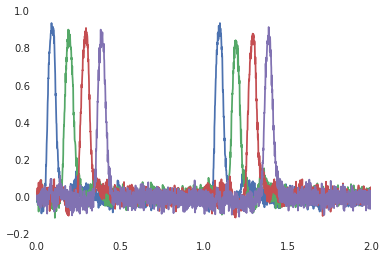

In [130]:
pylab.plot(sim.trange(), sim.data[p])
